In [8]:
# 01 - Data Ingestion and Cleaning

import pandas as pd
from pathlib import Path
import json

# --- Setup directories ---
DATA_DIR = Path("../data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Update this to your extracted dataset folder path
EXTRACTED_DIR = Path("../data/archive")  # or "../data" if you extracted there

# --- Find all CSV files ---
csv_files = list(EXTRACTED_DIR.glob("**/*.csv"))
print(f"Total CSV files found: {len(csv_files)}")

# --- Core columns to standardize ---
core_cols = [
    "state/ut", "district", "year", "murder", "rape", "robbery",
    "dacoity", "arson", "theft", "other_ipc_crimes", "total_ipc_crimes", "population"
]

dfs = []
for f in csv_files:
    try:
        df = pd.read_csv(f)
        df.columns = [c.strip().lower().replace(" ", "_").replace("/", "_").replace("&", "and") for c in df.columns]

        # --- Handle state/UT column variations ---
        if "state_ut" in df.columns:
            pass
        elif "state/ut" in df.columns:
            df.rename(columns={"state/ut": "state_ut"}, inplace=True)
        elif "states_uts" in df.columns:
            df.rename(columns={"states_uts": "state_ut"}, inplace=True)
        elif "state" in df.columns:
            df.rename(columns={"state": "state_ut"}, inplace=True)

        # --- Identify available columns ---
        existing_cols = [c for c in core_cols if c in df.columns]
        df = df[existing_cols]

        # --- Convert numeric columns safely ---
        for col in ["murder", "rape", "robbery", "dacoity", "arson", "theft", "other_ipc_crimes", "total_ipc_crimes", "population"]:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

        dfs.append(df)
        print(f"Processed: {f.name} | Columns: {list(df.columns)}")

    except Exception as e:
        print(f"Error reading {f.name}:", e)

# --- Combine all valid dataframes ---
if dfs:
    df_all = pd.concat(dfs, ignore_index=True)
    print("Combined shape:", df_all.shape)
else:
    raise ValueError("No valid CSVs to combine.")

# --- Compute crime rates (if population column exists) ---
if "population" in df_all.columns:
    crime_cols = ["murder", "rape", "robbery", "dacoity", "arson", "theft", "other_ipc_crimes", "total_ipc_crimes"]
    for col in crime_cols:
        df_all[col + "_per_100k"] = df_all[col] / df_all["population"].replace(0, 1) * 100000

# --- Drop duplicates and clean missing values ---
df_all.drop_duplicates(inplace=True)
df_all.fillna(0, inplace=True)

# --- Save cleaned dataset ---
output_file = DATA_DIR / "CrimeNet_master.csv"
df_all.to_csv(output_file, index=False)
print("✅ Cleaned dataset saved to:", output_file)

# --- Save dataset manifest ---
manifest = {
    "dataset": "Crime in India (Kaggle - rajanand)",
    "files": [f.name for f in csv_files],
    "output": str(output_file),
    "total_rows": len(df_all)
}

with open(DATA_DIR / "dataset_manifest.json", "w") as f:
    json.dump(manifest, f, indent=4)

print("✅ Manifest saved at:", DATA_DIR / "dataset_manifest.json")


Total CSV files found: 76
Processed: 01_District_wise_crimes_committed_IPC_2001_2012.csv | Columns: ['district', 'year', 'murder', 'rape', 'robbery', 'dacoity', 'arson', 'theft', 'other_ipc_crimes', 'total_ipc_crimes']
Processed: 01_District_wise_crimes_committed_IPC_2013.csv | Columns: ['district', 'year', 'murder', 'rape', 'robbery', 'dacoity', 'arson', 'theft', 'other_ipc_crimes', 'total_ipc_crimes']
Processed: 01_District_wise_crimes_committed_IPC_2014.csv | Columns: ['district', 'year', 'murder', 'rape', 'robbery', 'dacoity', 'arson', 'theft', 'other_ipc_crimes']
Processed: 02_01_District_wise_crimes_committed_against_SC_2001_2012.csv | Columns: ['district', 'year', 'murder', 'rape', 'robbery', 'dacoity', 'arson']
Processed: 02_01_District_wise_crimes_committed_against_SC_2013.csv | Columns: ['district', 'year', 'murder', 'rape', 'robbery', 'dacoity', 'arson']
Processed: 02_01_District_wise_crimes_committed_against_SC_2014.csv | Columns: ['district', 'year']
Processed: 02_District

✅ Dataset Loaded. Shape: (46891, 10)
Columns: ['district', 'year', 'murder', 'rape', 'robbery', 'dacoity', 'arson', 'theft', 'other_ipc_crimes', 'total_ipc_crimes']
    district    year  murder  rape  robbery  dacoity  arson  theft  \
0   ADILABAD  2001.0   101.0  50.0     41.0      9.0   30.0  199.0   
1  ANANTAPUR  2001.0   151.0  23.0     16.0      8.0   69.0  366.0   
2   CHITTOOR  2001.0   101.0  27.0     14.0      4.0   38.0  723.0   

   other_ipc_crimes  total_ipc_crimes  
0            1518.0            4154.0  
1             754.0            4125.0  
2            1262.0            5818.0  
               year        murder          rape      robbery       dacoity  \
count  46891.000000  46891.000000  46891.000000  46891.00000  46891.000000   
mean    2007.475081     21.590135     30.629566     14.11081      2.943017   
std       10.081758    159.301318    151.606093    132.70237     27.030910   
min        0.000000      0.000000      0.000000      0.00000      0.000000   
25% 

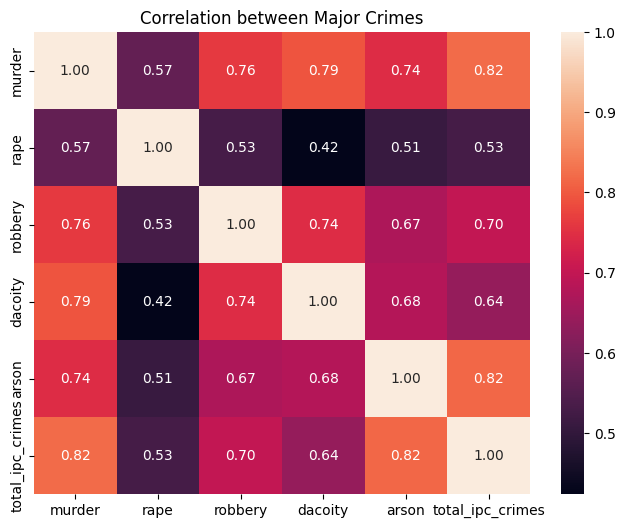

Aggregated shape: (10041, 9)
Generated 46876 edges for 1623 nodes
✅ Preprocessed data ready for GNN training.


In [9]:
# 02 - EDA + Feature Engineering

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

DATA_DIR = Path("../data")
df = pd.read_csv(DATA_DIR / "CrimeNet_master.csv")

print("✅ Dataset Loaded. Shape:", df.shape)
print("Columns:", list(df.columns))

# --- Basic info ---
print(df.head(3))
print(df.describe())
print(df.isnull().sum())

# --- Replace missing or zero year values if any ---
df['year'] = pd.to_numeric(df['year'], errors='coerce').fillna(0).astype(int)
df = df[df['year'] > 2000]

# --- Compute total violent crimes (as feature) ---
violent_features = ["murder", "rape", "robbery", "dacoity", "arson"]
df["total_violent_crimes"] = df[violent_features].sum(axis=1)

# --- Compute crime intensity index per district per year ---
if "population" in df.columns and df["population"].sum() > 0:
    df["crime_index"] = df["total_ipc_crimes"] / df["population"].replace(0, np.nan)
else:
    df["crime_index"] = df["total_ipc_crimes"] / df["total_ipc_crimes"].max()

# --- Check correlation between key crimes ---
plt.figure(figsize=(8,6))
sns.heatmap(df[violent_features + ["total_ipc_crimes"]].corr(), annot=True, fmt=".2f")
plt.title("Correlation between Major Crimes")
plt.show()

# --- Group by state/district/year ---
grouped = df.groupby(["district", "year"], as_index=False).agg({
    "murder":"sum", "rape":"sum", "robbery":"sum", "dacoity":"sum", "arson":"sum",
    "theft":"sum", "total_ipc_crimes":"sum"
})
print("Aggregated shape:", grouped.shape)

# --- Prepare data for GNN ---
# Create unique node ids for each district
district_map = {d:i for i, d in enumerate(df["district"].unique())}
df["district_id"] = df["district"].map(district_map)

# Create edges: link districts within same state (or similar region)
# Since state column may be missing, approximate by year proximity
edges = []
for _, grp in df.groupby("year"):
    ids = grp["district_id"].values
    for i in range(len(ids)-1):
        edges.append((ids[i], ids[i+1]))

print(f"Generated {len(edges)} edges for {len(district_map)} nodes")

# --- Save preprocessed data for GNN stage ---
df.to_csv(DATA_DIR / "CrimeNet_GNN_ready.csv", index=False)
np.save(DATA_DIR / "edges.npy", np.array(edges))

print("✅ Preprocessed data ready for GNN training.")




Total CSV files found: 76
✅ Processed: 01_District_wise_crimes_committed_IPC_2001_2012.csv | Columns: ['district', 'year', 'murder', 'rape', 'robbery', 'dacoity', 'arson', 'theft', 'other_ipc_crimes', 'total_ipc_crimes']
✅ Processed: 01_District_wise_crimes_committed_IPC_2013.csv | Columns: ['district', 'year', 'murder', 'rape', 'robbery', 'dacoity', 'arson', 'theft', 'other_ipc_crimes', 'total_ipc_crimes']
✅ Processed: 01_District_wise_crimes_committed_IPC_2014.csv | Columns: ['district', 'year', 'murder', 'rape', 'robbery', 'dacoity', 'arson', 'theft', 'other_ipc_crimes']
✅ Processed: 02_01_District_wise_crimes_committed_against_SC_2001_2012.csv | Columns: ['district', 'year', 'murder', 'rape', 'robbery', 'dacoity', 'arson']
✅ Processed: 02_01_District_wise_crimes_committed_against_SC_2013.csv | Columns: ['district', 'year', 'murder', 'rape', 'robbery', 'dacoity', 'arson']
✅ Processed: 02_01_District_wise_crimes_committed_against_SC_2014.csv | Columns: ['district', 'year']
✅ Processe

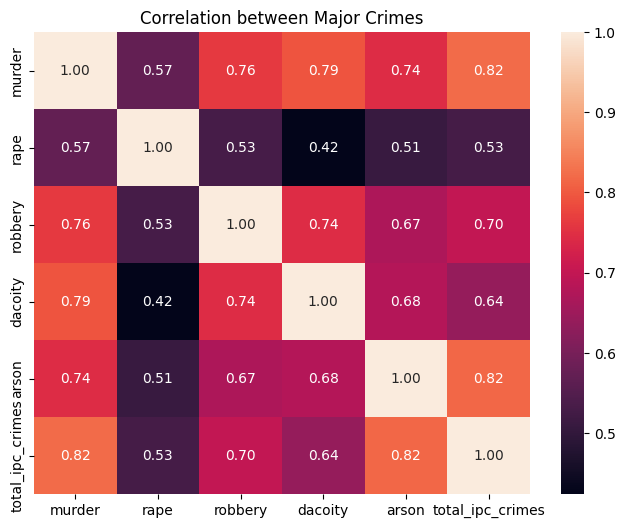

📈 Aggregated shape: (10041, 9)
🔥 Hotspot threshold: 3701.54
is_hotspot
0    7518
1    2523
Name: count, dtype: int64
🌐 Generated 10027 edges for 1623 districts

✅ Saved processed dataset to: ..\data\processed\crime_district_processed.csv
✅ Preprocessed data ready for GNN training.


In [11]:
# ===============================================================
# CrimeNet - 01_Data_Ingestion_and_Cleaning + 02_EDA_Feature_Engineering
# ===============================================================

import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ===============================================================
# 1️⃣ Setup Directories
# ===============================================================
DATA_DIR = Path("../data")
PROCESSED_DIR = DATA_DIR / "processed"
ARCHIVE_DIR = DATA_DIR / "archive"

DATA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# ===============================================================
# 2️⃣ Ingest All CSVs
# ===============================================================
csv_files = list(ARCHIVE_DIR.glob("**/*.csv"))
print(f"Total CSV files found: {len(csv_files)}")

core_cols = [
    "state/ut", "district", "year", "murder", "rape", "robbery",
    "dacoity", "arson", "theft", "other_ipc_crimes", "total_ipc_crimes", "population"
]

dfs = []
for f in csv_files:
    try:
        df = pd.read_csv(f)
        df.columns = [c.strip().lower().replace(" ", "_").replace("/", "_").replace("&", "and") for c in df.columns]

        if "state_ut" not in df.columns:
            if "state/ut" in df.columns:
                df.rename(columns={"state/ut": "state_ut"}, inplace=True)
            elif "states_uts" in df.columns:
                df.rename(columns={"states_uts": "state_ut"}, inplace=True)
            elif "state" in df.columns:
                df.rename(columns={"state": "state_ut"}, inplace=True)

        existing_cols = [c for c in core_cols if c in df.columns]
        df = df[existing_cols]

        num_cols = ["murder", "rape", "robbery", "dacoity", "arson", "theft", "other_ipc_crimes", "total_ipc_crimes", "population"]
        for col in num_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

        dfs.append(df)
        print(f"✅ Processed: {f.name} | Columns: {list(df.columns)}")

    except Exception as e:
        print(f"⚠️ Error reading {f.name}: {e}")

if not dfs:
    raise ValueError("No valid CSVs found. Check your ../data/archive folder.")

df_all = pd.concat(dfs, ignore_index=True)
print("📊 Combined shape:", df_all.shape)

# ===============================================================
# 3️⃣ Feature Engineering - Crime Rates
# ===============================================================
if "population" in df_all.columns:
    for col in ["murder", "rape", "robbery", "dacoity", "arson", "theft", "other_ipc_crimes", "total_ipc_crimes"]:
        df_all[col + "_per_100k"] = df_all[col] / df_all["population"].replace(0, 1) * 100000

df_all.drop_duplicates(inplace=True)
df_all.fillna(0, inplace=True)

# ===============================================================
# 4️⃣ Save Master Cleaned CSV
# ===============================================================
master_path = DATA_DIR / "CrimeNet_master.csv"
df_all.to_csv(master_path, index=False)
print("✅ Cleaned dataset saved to:", master_path)

# Manifest
manifest = {
    "dataset": "Crime in India (Kaggle - rajanand)",
    "files": [f.name for f in csv_files],
    "output": str(master_path),
    "total_rows": len(df_all)
}
with open(DATA_DIR / "dataset_manifest.json", "w") as f:
    json.dump(manifest, f, indent=4)
print("✅ Manifest saved at:", DATA_DIR / "dataset_manifest.json")

# ===============================================================
# 5️⃣ EDA + Additional Feature Engineering
# ===============================================================
df = pd.read_csv(master_path)
print("\n✅ Dataset Loaded for EDA:", df.shape)

df['year'] = pd.to_numeric(df['year'], errors='coerce').fillna(0).astype(int)
df = df[df['year'] > 2000]

violent_features = ["murder", "rape", "robbery", "dacoity", "arson"]
df["total_violent_crimes"] = df[violent_features].sum(axis=1)

if "population" in df.columns and df["population"].sum() > 0:
    df["crime_index"] = df["total_ipc_crimes"] / df["population"].replace(0, np.nan)
else:
    df["crime_index"] = df["total_ipc_crimes"] / df["total_ipc_crimes"].max()

plt.figure(figsize=(8,6))
sns.heatmap(df[violent_features + ["total_ipc_crimes"]].corr(), annot=True, fmt=".2f")
plt.title("Correlation between Major Crimes")
plt.show()

grouped = df.groupby(["district", "year"], as_index=False).agg({
    "murder": "sum",
    "rape": "sum",
    "robbery": "sum",
    "dacoity": "sum",
    "arson": "sum",
    "theft": "sum",
    "total_ipc_crimes": "sum"
})
print("📈 Aggregated shape:", grouped.shape)

# ===============================================================
# 6️⃣ Compute District Features & Hotspot Label
# ===============================================================
df_features = grouped.groupby("district").agg({
    "murder": ["mean", "std"],
    "rape": ["mean", "std"],
    "robbery": ["mean", "std"],
    "dacoity": ["mean", "std"],
    "arson": ["mean", "std"],
    "theft": ["mean", "std"],
    "total_ipc_crimes": ["mean", "std"]
})
df_features.columns = ["_".join(c) for c in df_features.columns]
df_features = df_features.reset_index()

df_final = pd.merge(grouped, df_features, on="district", how="left")

threshold = df_final["total_ipc_crimes_mean"].quantile(0.75)
df_final["is_hotspot"] = (df_final["total_ipc_crimes_mean"] >= threshold).astype(int)

print(f"🔥 Hotspot threshold: {threshold:.2f}")
print(df_final["is_hotspot"].value_counts())

# ===============================================================
# 7️⃣ Generate Edges for GNN
# ===============================================================
district_map = {d: i for i, d in enumerate(df_final["district"].unique())}
df_final["district_id"] = df_final["district"].map(district_map)

edges = []
for _, grp in df_final.groupby("year"):
    ids = grp["district_id"].values
    for i in range(len(ids) - 1):
        edges.append((ids[i], ids[i + 1]))

print(f"🌐 Generated {len(edges)} edges for {len(district_map)} districts")

# ===============================================================
# 8️⃣ Save Final Processed Files
# ===============================================================
df_final.to_csv(PROCESSED_DIR / "crime_district_processed.csv", index=False)
np.save(DATA_DIR / "edges.npy", np.array(edges))
df_final.to_csv(DATA_DIR / "CrimeNet_GNN_ready.csv", index=False)

print("\n✅ Saved processed dataset to:", PROCESSED_DIR / "crime_district_processed.csv")
print("✅ Preprocessed data ready for GNN training.")
